## 모듈 import

In [1]:
# 모듈 import
import os
import glob
import json
import pprint

import numpy as np
import pandas as pd

from lightgbm import LGBMClassifier
import lightgbm as lgb

from tqdm import tqdm # python 반복문의 진행률을 표시하기 위한 라이브러리 사용

from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import RFE
from sklearn.feature_extraction import FeatureHasher

import matplotlib.pyplot as plt # 각 데이터의 feature importance를 알기 위한 그래프 라이브러리 사용
%matplotlib inline

In [2]:
local_dir = "/Users/yeonsun/Documents/2021_InformationAndSystemSecurity/AI_Malware_Detect/데이터"

## read_label 함수, read_json 함수, load_model 함수, train 함수, evaluate 함수

In [3]:
SEED = 41

# 정답 파일을 읽어 key: 파일이름, value: 1(또는 0)을 가지는 dictionary
# dictionary에 파일이름을 검색하면 해당 파일의 정답을 알 수 있음
def read_label_csv(path):
    label_table = dict()
    with open(path, "r", encoding='ISO-8859-1') as f: # 인코딩
        for line in f.readlines()[1:]:
            fname, label = line.strip().split(",")
            label_table[fname] = int(label)
    return label_table


# json파일 불러오는 함수
def read_json(path):
    with open(path, "r") as f:
        return json.load(f)

    
# 머신러닝 정의하는 함수
def load_model(**kwargs):
    if kwargs["model"] == "rf":
        return ["rf", RandomForestClassifier(random_state=kwargs["random_state"], n_jobs=4)]
    elif kwargs["model"] == "dt":
        return ["dt", DecisionTreeClassifier(random_state=kwargs["random_state"])]
    elif kwargs["model"] == "lgb":
        return ["lgb", LGBMClassifier(random_state=kwargs["random_state"])]
    elif kwargs["model"] == "svm":
        return ["svm", SVC(random_state=kwargs["random_state"], probability=True)]
    elif kwargs["model"] == "lr":
        return ["lr", LogisticRegression(random_state=kwargs["random_state"], n_jobs=-1, max_iter=30000)] # max_iter: Gradient Descent 방식을 반복할 횟수를 정하는 파라미터
    elif kwargs["model"] == "knn":
        return ["knn", KNeighborsClassifier(n_jobs=-1)]
    elif kwargs["model"] == "adaboost":
        return ["adaboost", AdaBoostClassifier(random_state=kwargs["random_state"])]
    elif kwargs["model"] == "mlp":
        return ["mlp", MLPClassifier(random_state=kwargs["random_state"])]
    else:
        print("Unsupported Algorithm")
        return None
    

# 머신러닝 모델을 선택하여 학습을 진행하는 함수
# param X_train: 학습할 2차원 리스트 특징벡터
# param y_train: 학습할 1차원 리스트 레이블 벡터
# param model: 문자열, 선택할 머신러닝 알고리즘
# return: 학습된 머신러닝 모델 객체
def train(X_train, y_train, model):
    model, clf = load_model(model=model, random_state=SEED)
    clf.fit(X_train, y_train)
    return [model, clf]


# 학습된 머신러닝 모델로 검증 데이터를 검증하는 함수	
# param X_test: 검증할 2차원 리스트 특징 벡터
# param y_test: 검증할 1차원 리스트 레이블 벡터
# param model: 학습된 머신러닝 모델 객체
def evaluate(X_test, y_test, model):
    predict = model[1].predict(X_test)
    if model[0] == "rf":
        print("RandomForest 정확도 : ", model[1].score(X_test, y_test))
    elif model[0] == "dt":
        print("DecisionTree 정확도 : ", model[1].score(X_test, y_test))
    elif model[0] == "lgb":
        print("LGBM 정확도 : ", model[1].score(X_test, y_test))
    elif model[0] == "svm":
        print("SVM 정확도 : ", model[1].score(X_test, y_test))
    elif model[0] == "lr":
        print("LogisticRegression 정확도 : ", model[1].score(X_test, y_test))
    elif model[0] == "knn":
        print("KNN 정확도 : ", model[1].score(X_test, y_test))
    elif model[0] == "adaboost":
        print("AdaBoost 정확도 : ", model[1].score(X_test, y_test))
    elif model[0] == "mlp":
        print("MLP 정확도 : ", model[1].score(X_test, y_test))

## 레이블 테이블 로드

In [4]:
label_table = read_label_csv(local_dir + "/학습데이터_정답.csv")
check_label_table = read_label_csv(local_dir + "/검증데이터_정답.csv")

## 특징 벡터 생성 예시
- PEMINER 정보는 모두 수치형 데이터이므로 특별히 가공을 하지 않고 사용 가능
- EMBER, PESTUDIO 정보는 가공해서 사용해야 할 특징들이 있음 (e.g. imports, exports 등의 문자열 정보를 가지는 데이터)
- 수치형 데이터가 아닌 데이터(범주형 데이터)를 어떻게 가공할 지가 관건 >> 인코딩 (e.g. 원핫인코딩, 레이블인코딩 등)

In [5]:
# PEMINER 데이터 json 파일에서 모든 데이터 추출 - 188개
class PeminerParser:
    def __init__(self, path):
        self.report = read_json(path)
        self.vector = []
    
    def process_report(self):
        '''
            전체 데이터 사용        
        '''
        
        self.vector = [value for _, value in sorted(self.report.items(), key=lambda x: x[0])]
        return self.vector

In [6]:
# EMBER 데이터 json 파일에서 모든 데이터 추출 - 202개
class EmberParser:
    '''
        예제에서 사용하지 않은 특징도 사용하여 벡터화 할 것을 권장
    '''
    def __init__(self, path):
        self.report = read_json(path)
        self.vector = []
        
    # def get_histogram_info(self):
    #     histogram = np.array(self.report["histogram"])
    #     total = histogram.sum()
    #     vector = histogram / total
    #     return vector.tolist()
    
    # def get_string_info(self):
    #     strings = self.report["strings"]

    #     hist_divisor = float(strings['printables']) if strings['printables'] > 0 else 1.0
    #     vector = [
    #         strings['numstrings'], 
    #         strings['avlength'], 
    #         strings['printables'],
    #         strings['entropy'], 
    #         strings['paths'], 
    #         strings['urls'],
    #         strings['registry'], 
    #         strings['MZ']
    #     ]
    #     vector += (np.asarray(strings['printabledist']) / hist_divisor).tolist()
    #     return vector
    
    # def get_general_file_info(self):
    #     general = self.report["general"]
    #     vector = [
    #         general['size'], general['vsize'], general['has_debug'], general['exports'], general['imports'],
    #         general['has_relocations'], general['has_resources'], general['has_signature'], general['has_tls'],
    #         general['symbols']
    #     ]
    #     return vector
    
    # general의 imports 추출
    def get_import_info(self): 
        general = self.report["general"]
        vector = [
            general['imports']
        ]
        return vector
    
    # general의 exports 추출
    # def get_export_info(self): 
    #     general = self.report["general"]
    #     vector = [
    #         general['exports']
    #     ]
    #     return vector

    # section의 수치화 된 데이터 일부 추출
    def get_section_info(self): 
        section = self.report["section"]
        vector = [
            len(section["sections"]) # section의 sections의 길이 추출
        ]
        # name(파일의 확장자)과 size를 한 쌍으로 묶어서 추출
        section_sizes = [(s['name'], s['size']) for s in section["sections"]] 
        vector.extend(FeatureHasher(50, input_type="pair").transform([section_sizes]).toarray()[0]) # section_sizes_hashed
        # name과 entropy를 한 쌍으로 묶어서 추출
        section_entropy = [(s['name'], s['entropy']) for s in section["sections"]]
        vector.extend(FeatureHasher(50, input_type="pair").transform([section_entropy]).toarray()[0]) # section_entropy_hashed
        # name과 vsize를 한 쌍으로 묶어서 추출
        section_vsize = [(s['name'], s['vsize']) for s in section["sections"]]
        vector.extend(FeatureHasher(50, input_type="pair").transform([section_vsize]).toarray()[0]) # section_vsize_hashed
        # name과 entry가 같을 때, props 추출
        props = [p for s in section["sections"] for p in s['props'] if s['name'] == section['entry']]
        vector.extend(FeatureHasher(50, input_type="string").transform([props]).toarray()[0]) # props_hashed
        return vector


    def process_report(self):
        vector = []
        # vector += self.get_histogram_info()
        # vector += self.get_string_info()
        # vector += self.get_general_file_info()
        vector += self.get_import_info()
        # vector += self.get_export_info()
        vector += self.get_section_info()
        return vector

In [7]:
# PESTUDIO 데이터 json 파일에서 모든 데이터 추출 - 7개
class PestudioParser:
    '''
        사용할 특징을 선택하여 벡터화 할 것을 권장
    '''
    
    def __init__(self, path):
        try:
            self.report = read_json(path)
        except FileNotFoundError:
            self.report = None
        self.vector = []

     # overview의 수치화 된 데이터 중 entropy 추출
    def get_image_info(self):
        image = self.report["image"]
        vector = [float(image["overview"]["entropy"])]
        return vector

    # incidators의 severity가 1인 비율을 추출
    def get_indicator_info(self): 
        indicators = self.report["image"]["indicators"]
        try:
            vector = [sum(1 for s in indicators["indicator"] if s["@severity"] == "1") / len(indicators["indicator"])]
        except KeyError:
            vector = [-1]
        return vector

    # dos-header의 size(크기) 추출
    def get_dosHeader_info(self):
        try:
            header = self.report["image"]["dos-header"]
            vector = [int(header["size"])]
        except KeyError:
            vector = [-1]
        return vector

    # dos-stub의 size(크기) 추출
    # def get_dosStub_info(self): 
    #     try:
    #         stub = self.report["image"]["dos-stub"]
    #         vector = [int(stub["size"])]
    #     except KeyError:
    #         vector = [-1]
    #     return vector

    # optional-header의 file-checksum을 16진수에서 10진수로 변환하여 추출
    # def get_optionalHeader_info(self): 
    #     try:
    #         header = self.report["image"]["optional-header"]
    #         vector = [ int(header["file-checksum"], 16) ]
    #     except:
    #         vector = [-1]
    #     return vector

    # directories의 @size가 0이 아닌 요소들의 합 추출
    # def get_directories_info(self): 
    #     try:
    #         directory = self.report["image"]["directories"]["directory"]
    #         vector = [sum(1 for d in directory if d["@size"] != "0")]
    #     except KeyError:
    #         vector = [-1]
    #     return vector

    # libraries의 @blacklist가 "x"인 요소들의 비율 추출
    def get_libraries_info(self): 
        try:
            libraries = self.report["image"]["libraries"]
            if libraries == "n/a" or len(libraries) == 1:
                vector = [0]
            else:
                try:
                    vector = [sum(1 for i in libraries["library"] if i["@blacklist"] == "x") / len(libraries["library"])]
                except TypeError:
                    vector = [1 if libraries["library"]["@blacklist"] == "x" else 0]
        except:
            vector = [-1]
        return vector

    # imports의 @blacklist가 "x"인 요소들의 비율 추출
    def get_imports_info(self): 
        try:
            imports = self.report["image"]["imports"]
            if imports == "n/a" or len(imports) == 1:
                vector = [0]
            else:
                try:
                    vector = [sum(1 for i in imports["import"] if i["@blacklist"] == "x") / len(imports["import"])]
                except TypeError:
                    vector = [1 if imports["import"]["@blacklist"] == "x" else 0]
        except:
            vector = [-1]
        return vector

    # exports의 export 요소의 개수 추출
    # def get_exports_info(self): 
    #     try:
    #         exports = self.report["image"]["exports"]
    #         vector = [0 if exports == "n/a" else len(exports["export"])]
    #     except:
    #         vector = [-1]
    #     return vector

    # strings의 @bl, @count 추출
    def get_strings_info(self): 
        strings = self.report["image"]["strings"]
        vector = [
            float(strings["@bl"]),
            float(strings["@count"])
        ]
        return vector
    
    def process_report(self):
        vector = []

        if self.report:
            vector += self.get_image_info()
            vector += self.get_indicator_info()
            vector += self.get_dosHeader_info()
            # vector += self.get_dosStub_info()
            # vector += self.get_optionalHeader_info()
            # vector += self.get_directories_info()
            vector += self.get_libraries_info()
            vector += self.get_imports_info()
            # vector += self.get_exports_info()
            vector += self.get_strings_info()
        else: 
            # FileNotFoundError인 경우 vector에 -1 값 넣어서 추출
            vector = [-1 for _ in range(7)]
        return vector


## 데이터 벡터 구성
- 특징 벡터 구성은 2차원이 되어야함 e.g.  [vector_1, vector_2, ..., vector_n]
- 각 벡터는 1차원 리스트, 벡터 크기는 모두 같아야함

## 학습데이터 X, y

In [8]:
# 학습데이터
peminer_url = (local_dir + '/PEMINER/학습데이터/')
ember_url = (local_dir + '/EMBER/학습데이터/')
pestudio_url = (local_dir + '/PESTUDIO/학습데이터/')

# 데이터의 특징 벡터 모음(2차원 리스트) : X
# 데이터의 레이블 모음(1차원 리스트) : y
X, y = [], []

for fname in list(label_table.keys()):
    feature_vector = []
    label = label_table[fname.split('.')[0]]

    for data in [peminer_url, ember_url, pestudio_url]:
        path = f"{data}/{fname}.json"
        if data == peminer_url:
            feature_vector += PeminerParser(path).process_report()
        elif data == ember_url:
            feature_vector += EmberParser(path).process_report()
        else:
            feature_vector += PestudioParser(path).process_report()
            
    X.append(feature_vector)
    y.append(label)

np.asarray(X).shape, np.asarray(y).shape

((20000, 397), (20000,))

## 검증데이터 valid_X, valid_y

In [9]:
# 검증데이터
perminer_check_url = (local_dir + '/PEMINER/검증데이터')
ember_check_url = (local_dir + '/EMBER/검증데이터')
pestudio_check_url = (local_dir + '/PESTUDIO/검증데이터')

# 데이터의 특징 벡터 모음(2차원 리스트) : X
# 데이터의 레이블 모음(1차원 리스트) : y
valid_X, vaild_y = [], []

for fname in list(check_label_table.keys()):
    feature_vector = []
    label = check_label_table[fname.split('.')[0]]

    for data in [perminer_check_url, ember_check_url, pestudio_check_url]:
        path = f"{data}/{fname}.json"
        if data == perminer_check_url:
            feature_vector += PeminerParser(path).process_report()
        elif data == ember_check_url:
            feature_vector += EmberParser(path).process_report()
        else:
            feature_vector += PestudioParser(path).process_report()
            
    valid_X.append(feature_vector)
    vaild_y.append(label)

np.asarray(valid_X).shape, np.asarray(vaild_y).shape

((10000, 397), (10000,))

## model 여러개 학습 및 검증

In [10]:
# model 여러개 학습
model_name = ["rf", "dt", "lgb", "svm", "lr", "knn", "adaboost", "mlp"]
models = []
for model in tqdm(model_name):
    model, clf = train(X, y, model)
    models.append([model, clf])
print('Finished training.')

# 검증
for model in tqdm(models): 
    evaluate(valid_X, vaild_y, model)
print('Finished evaluation.')

100%|██████████| 8/8 [13:19<00:00, 99.94s/it] 


Finished training.


 12%|█▎        | 1/8 [00:00<00:03,  1.91it/s]

RandomForest 정확도 :  0.9567


 25%|██▌       | 2/8 [00:00<00:02,  2.24it/s]

DecisionTree 정확도 :  0.9272


 38%|███▊      | 3/8 [00:01<00:02,  2.48it/s]

LGBM 정확도 :  0.9575


 50%|█████     | 4/8 [00:47<01:14, 18.60s/it]

SVM 정확도 :  0.8269


 62%|██████▎   | 5/8 [00:48<00:36, 12.03s/it]

LogisticRegression 정확도 :  0.8417


 75%|███████▌  | 6/8 [00:58<00:22, 11.49s/it]

KNN 정확도 :  0.905


 88%|████████▊ | 7/8 [00:59<00:07,  7.92s/it]

AdaBoost 정확도 :  0.9062


100%|██████████| 8/8 [00:59<00:00,  7.45s/it]

MLP 정확도 :  0.8337
Finished evaluation.


## 앙상블 evaluate 함수

In [11]:
def ensemble_result(X, y, models):
    '''
        학습된 모델들의 결과를 앙상블하는 함수
	
        :param X: 검증할 2차원 리스트 특징 벡터
        :param y: 검증할 1차원 리스트 레이블 벡터
        :param models: 1개 이상의 학습된 머신러닝 모델 객체를 가지는 1차원 리스트
    '''
    
    # Soft Voting
    # https://devkor.tistory.com/entry/Soft-Voting-%EA%B3%BC-Hard-Voting
    predicts = []
    for model in tqdm(models):
        prob = [result for _, result in model[1].predict_proba(X)]
        predicts.append(prob)
    
    predict = np.mean(predicts, axis=0)
    predict = [1 if x >= 0.5 else 0 for x in predict]
        
    print("emsemble 정확도 : ", accuracy_score(y, predict))

## 앙상블 학습 및 검증

In [12]:
# ensemble 학습
models = []
for model in tqdm(["rf", "lgb"]):
    clf = train(X, y, model)
    models.append(clf)
print('Finished training.')

# ensemble 검증
ensemble_result(valid_X, vaild_y, models)
print('Finished evaluation.')

100%|██████████| 2/2 [00:03<00:00,  1.71s/it]


Finished training.


100%|██████████| 2/2 [00:00<00:00,  4.93it/s]

emsemble 정확도 :  0.961
Finished evaluation.


## 특징 선택 예제 (RFE 알고리즘 사용)

In [13]:
def select_feature(X, y, model):
    '''
        주어진 특징 벡터에서 특정 알고리즘 기반 특징 선택
        
        본 예제에서는 RFE 알고리즘 사용
        https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE.fit_transform
        
        :param X: 검증할 2차원 리스트 특징 벡터
        :param y: 검증할 1차원 리스트 레이블 벡터
        :param model: 문자열, 특징 선택에 사용할 머신러닝 알고리즘
    '''
    
    model, clf = load_model(model=model, random_state=SEED)
    rfe = RFE(estimator=clf)
    return rfe.fit_transform(X, y)

## 테스트데이터 test_X
- 테스트데이터의 파일명 추출하여 테스트 레이블 테이블 만들기

In [20]:
def get_testdata_filename():
    return [i[:-5] for i in os.listdir(local_dir + '/EMBER/테스트데이터')]

In [21]:
test_label_table = get_testdata_filename()

## test 데이터 test_X

In [22]:
# 테스트 데이터
peminer_test_url = (local_dir + '/PEMINER/테스트데이터')
ember_test_url = (local_dir + '/EMBER/테스트데이터')
pestudio_test_url = (local_dir + '/PESTUDIO/테스트데이터')

# 데이터의 특징 벡터 모음(2차원 리스트) : X
test_X = []

for fname in tqdm(test_label_table):
    feature_vector = []
    for data in [peminer_test_url, ember_test_url, pestudio_test_url]:
        path = f"{data}/{fname}.json"
        if data == peminer_test_url:
            feature_vector += PeminerParser(path).process_report()
        elif data == ember_test_url:
            feature_vector += EmberParser(path).process_report()
        else:
            feature_vector += PestudioParser(path).process_report()
    test_X.append(feature_vector)

np.asarray(test_X).shape

100%|██████████| 10000/10000 [00:55<00:00, 179.71it/s]


(10000, 397)

## test_X 검증

In [23]:
def ensemble_result(X, models):
    '''
        학습된 모델들의 결과를 앙상블하는 함수
        :param models: 1개 이상의 학습된 머신러닝 모델 객체를 가지는 1차원 리스트
    '''
    
    # Soft Voting
    # https://devkor.tistory.com/entry/Soft-Voting-%EA%B3%BC-Hard-Voting
    predicts = []
    for model in tqdm(models):
        prob = [result for _, result in model[1].predict_proba(X)]
        predicts.append(prob)
    
    predict = np.mean(predicts, axis=0)
    predict = [1 if x >= 0.5 else 0 for x in predict]
    
    return predict

In [24]:
predict = ensemble_result(test_X, models)
# print(predict)
print('Finished evaluation.')

100%|██████████| 2/2 [00:00<00:00,  4.94it/s]

Finished evaluation.


## test result csv 파일 생성

In [25]:
submission_csv = pd.DataFrame(columns=['file', 'predict'])
predictions = pd.DataFrame(predict,columns = ['predict'])
test_frame = pd.DataFrame(get_testdata_filename())
submission_csv["predict"] = predictions["predict"]
submission_csv["file"] = test_frame
submission_csv.to_csv("predict.csv", index=False)

## feature importance 그래프

In [26]:
# model 여러개 학습
model_name = ["lgb"]
models = []
clfs = []
for model in tqdm(model_name):
    model, clf = train(X, y, model)
    models.append([model, clf])
    clfs.append(clf)
print('Finished training.')

# 검증
for model in tqdm(models): 
    evaluate(valid_X, vaild_y, model)
print('Finished evaluation.')

100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


Finished training.


100%|██████████| 1/1 [00:00<00:00,  2.93it/s]

LGBM 정확도 :  0.9575
Finished evaluation.


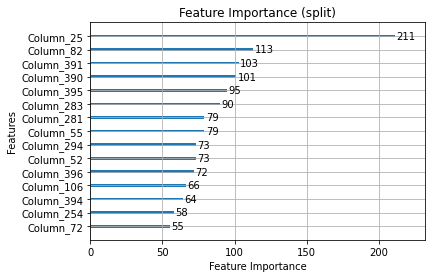

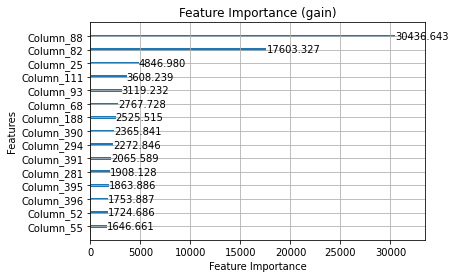

In [27]:
# SPLIT
ax = lgb.plot_importance(clf, max_num_features=15, importance_type='split')
ax.set(title=f'Feature Importance (split)',
		xlabel='Feature Importance',
		ylabel='Features')

# GAIN
ax = lgb.plot_importance(clf, max_num_features=15, importance_type='gain')
ax.set(title=f'Feature Importance (gain)',
		xlabel='Feature Importance',
		ylabel='Features')

plt.show()